In [218]:
import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np
import os


## Psychopy Related Functions

In [75]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals

## Shimmer Related Functions

In [112]:
def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp


def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    







## Time domain analysis for hrv

In [299]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [316]:
psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"
ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

col_interest_psychopy = "tsst_prep_ts"


In [317]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, col_interest_psychopy)
start_timestamp = non_nan_timestamp[0]

## offset time in min
time_offset = 5
stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)

In [318]:
print(start_timestamp)
print(stop_timestamp)

1699449933.583112
1699450233.583112


In [319]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print(start_time)
print(end_time)

2023-11-08 14:25:33.583112+01:00
2023-11-08 14:30:33.583112+01:00


In [320]:
ecg_df = read_shimmer_sensor(ecg_file_path)

In [315]:
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)

In [322]:
sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
#sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

In [323]:
start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print(start_time_hr)
print(end_time_hr)

2023-11-08 14:25:33.584412+01:00
2023-11-08 14:30:33.580505+01:00


In [327]:
sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

In [335]:
sliced_ecg_df.index

Int64Index([156137, 156138, 156139, 156140, 156141, 156142, 156143, 156144,
            156145, 156146,
            ...
            232906, 232907, 232908, 232909, 232910, 232911, 232912, 232913,
            232914, 232915],
           dtype='int64', length=76779)

## Extract Heart rate variability (HRV) from time-domain signal

In [329]:
# sampling frequency for ECG sensor
sampling_frequency = 256
settings = {}
settings["fs"] = sampling_frequency

#style setting 
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

In [146]:
plt.figure(figsize=(20, 7))

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

In [360]:
start = 0
stop = 2560
duration = (stop-start) / settings["fs"]


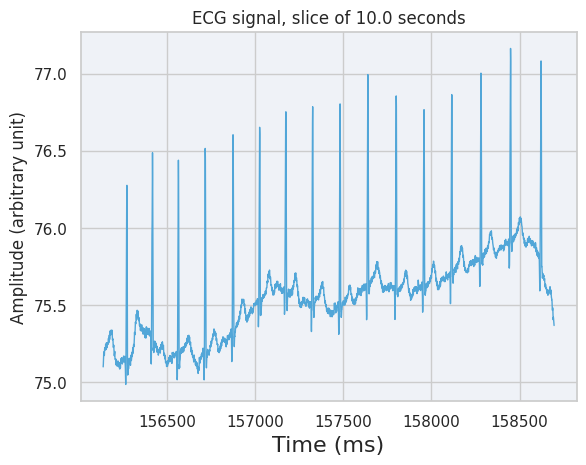

In [362]:

plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(sliced_ecg_df[start:stop].index, sliced_ecg_df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [367]:
sliced_ecg_df

,Shimmer_6B1E_Timestamp_Unix_CAL,Shimmer_6B1E_ECG_LA-RA_24BIT_CAL,heartrate
156137,1.699450e+09,75.0988817332842,75.098882
156138,1.699450e+09,75.11842669468244,75.118427
156139,1.699450e+09,75.15189113043442,75.151891
156140,1.699450e+09,75.1817494847476,75.181749
156141,1.699450e+09,75.19054832345824,75.190548
...,...,...,...
232911,1.699450e+09,74.02607250524431,74.026073
232912,1.699450e+09,74.05254114300503,74.052541
232913,1.699450e+09,74.05340660255034,74.053407
232914,1.699450e+09,74.05434418372442,74.054344


In [375]:
starting_index_slcide_df

156137

156137
161137


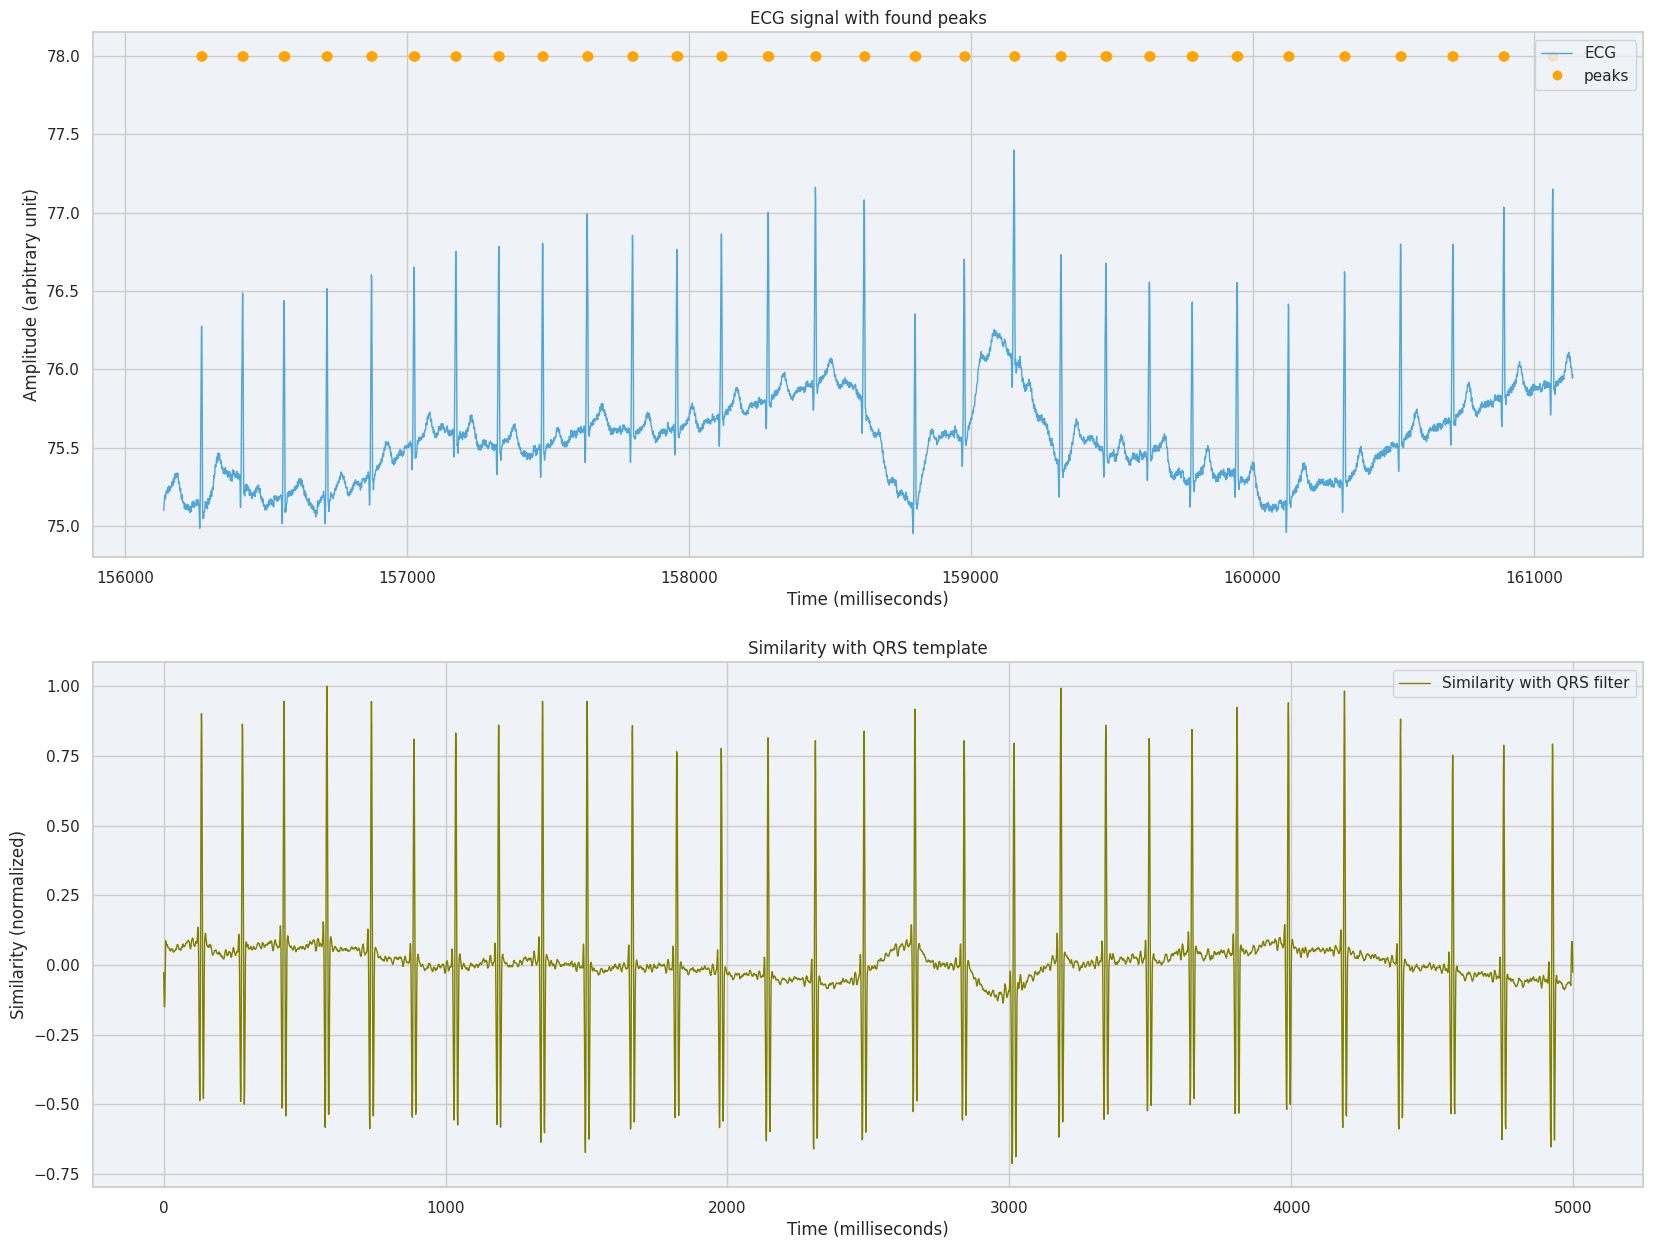

In [386]:
starting_index_slcide_df= sliced_ecg_df.index[0]
sampfrom = starting_index_slcide_df
sampto = starting_index_slcide_df+5000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.heartrate[cond_slice]

    # detect peaks
    
    peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(78, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

## multiple peaks to single peak for each QRS complex. 

In [387]:
sliced_ecg_hrv

156137    75.098882
156138    75.118427
156139    75.151891
156140    75.181749
156141    75.190548
            ...    
161132    76.006749
161133    75.968092
161134    75.956696
161135    75.943138
161136    75.965351
Name: heartrate, Length: 5000, dtype: float64

In [388]:
sliced_ecg_df.index

Int64Index([156137, 156138, 156139, 156140, 156141, 156142, 156143, 156144,
            156145, 156146,
            ...
            232906, 232907, 232908, 232909, 232910, 232911, 232912, 232913,
            232914, 232915],
           dtype='int64', length=76779)

In [390]:
# detect peaks
peaks, similarity = detect_peaks(sliced_ecg_df.heartrate, threshold=0.3)
# group peaks
grouped_peaks = group_peaks(peaks)

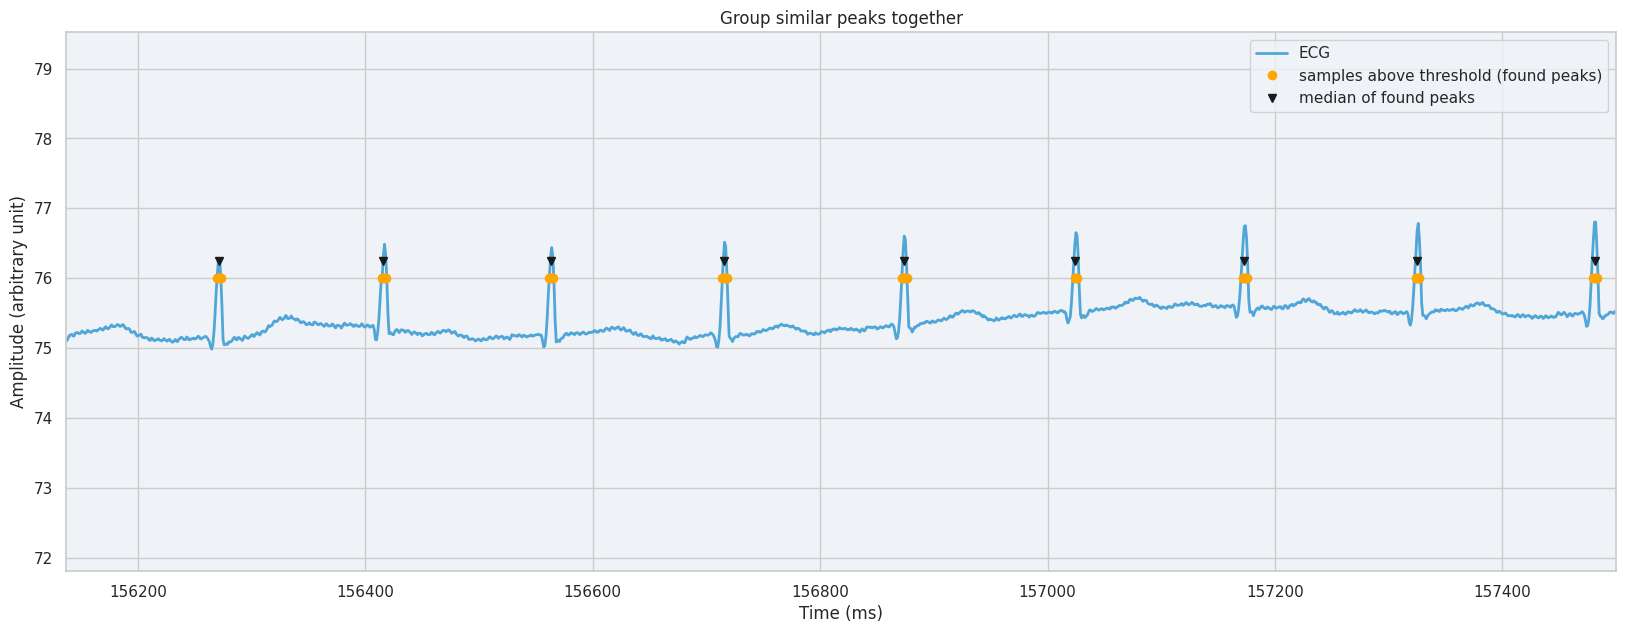

In [394]:

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(sliced_ecg_df.index, sliced_ecg_df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(76., peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(76.25, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(156137, 157500)
plt.show()


## RR intervals: difference between successive peaks

In [395]:
# RR-intervals are the differences between successive peaks

# detect peaks
peaks, similarity = detect_peaks(sliced_ecg_df.heartrate, threshold=0.3)
#sliced_ecg_df[start:stop].index, sliced_ecg_df[start:stop].heartrate
#peaks, similarity = detect_peaks(sliced_ecg_df[start:stop].heartrate, threshold=0.3)
#group peaks
grouped_peaks = group_peaks(peaks)
## RR-intervals are the differences between successive peak
rr = np.diff(grouped_peaks)

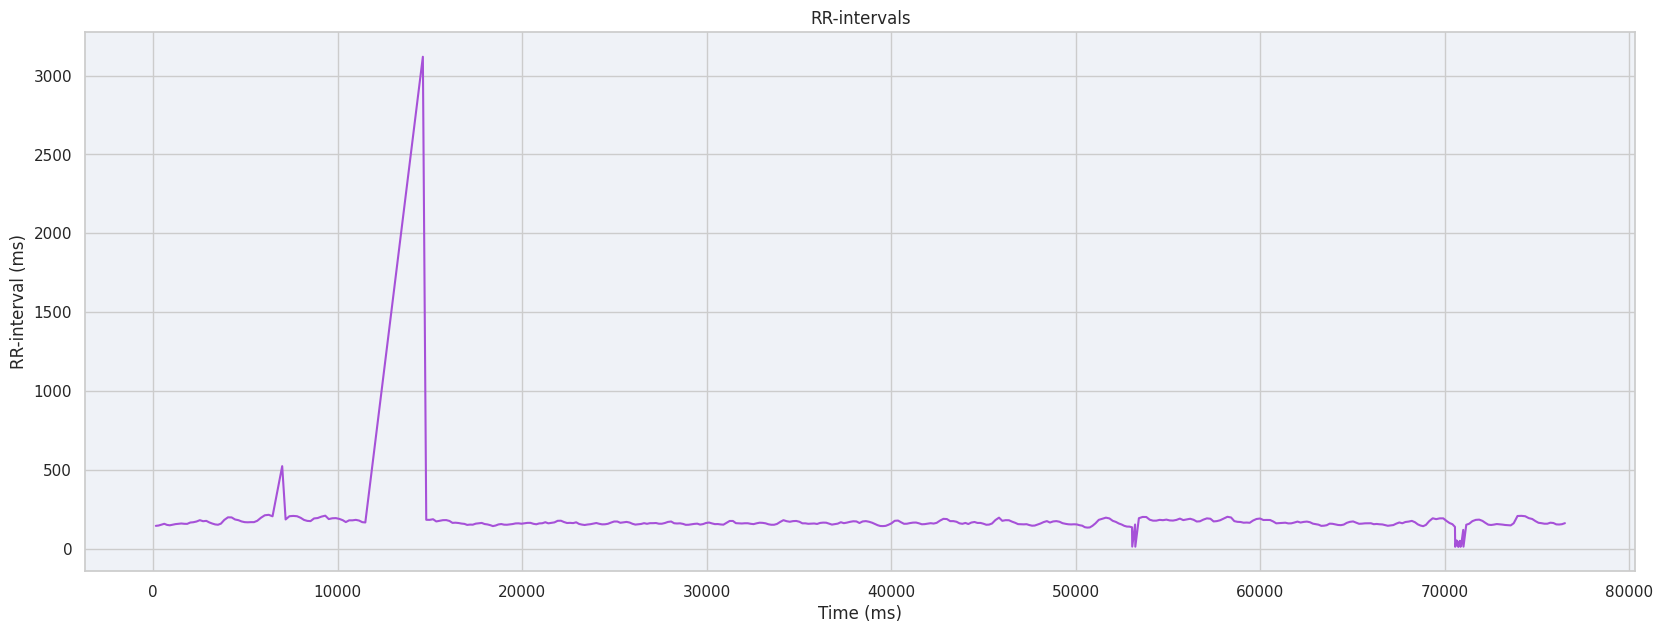

In [396]:
# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

Text(474.14158665401385, 0.004, 'outliers high (> mean + 2 sigma)')

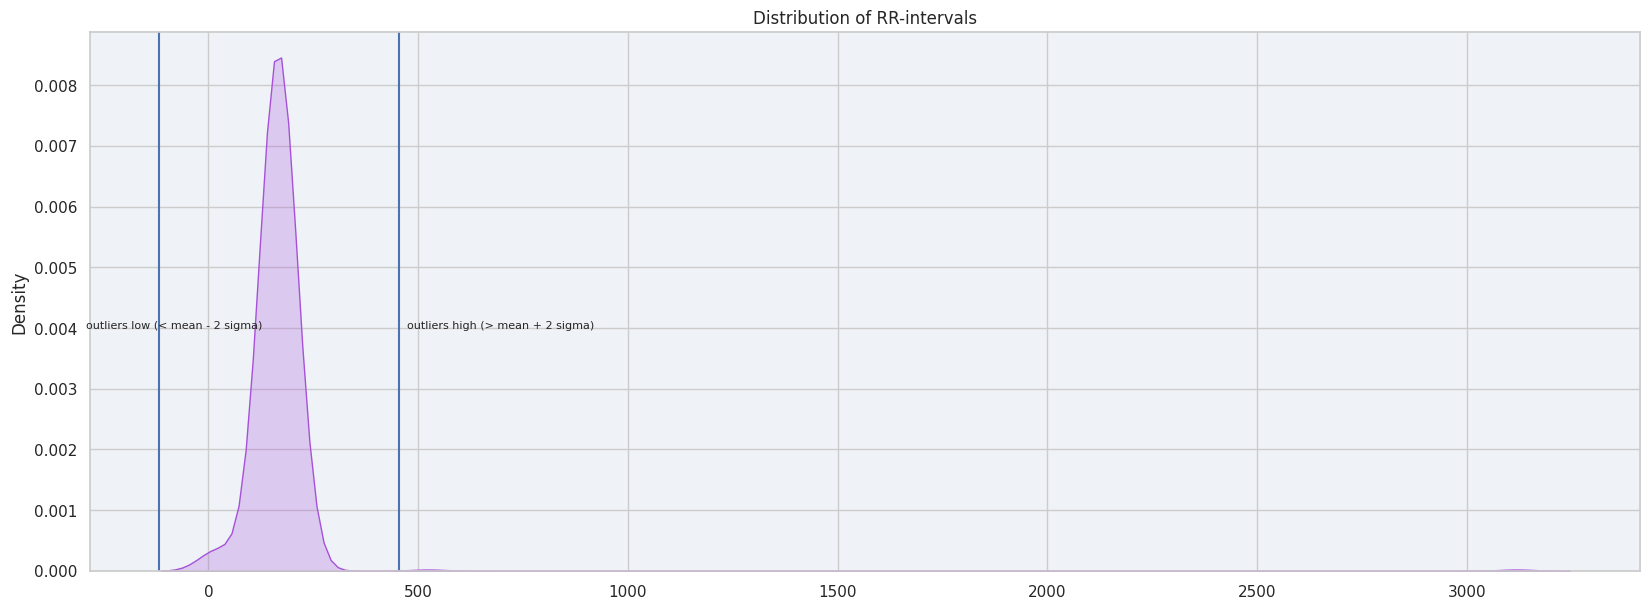

In [397]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)
    
   
outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")

plt.text(outlier_low - 175, 0.004, "outliers low (< mean - 2 sigma)", fontsize = 8)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize = 8)
    